In [1]:
import sys
import numpy as np
import pickle
sys.path.insert(1, "/data/chamal/projects/natvik/sir_extended/analysis/SIR_mouse/model")
from AgentBasedModel import AgentBasedModel
from scipy.stats import zscore, norm
from tqdm import tqdm
import argparse
import time
import pandas as pd
import scipy.stats

/opt/quarantine/software/anaconda/2022.05/install/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load old parameters

Note: can repeat everything for retro, just be careful to change output file names

In [11]:
with open('/data/chamal/projects/natvik/sir_extended/analysis/params_nature_yohan_ccfv3.pkl', "rb") as f:
            params = pickle.load(f)
            # if retro is False, load data from 'params_nature.pickle'; anterograde spreading
            
weights = params['weights']
distance = params['distance'] #cannot be replaced by Knox data. use Shady values for 213 regions
region_size = params['region_size']
sources = params['sources']
targets = params['targets'] #213 source, 426 target (contralateral/ipsilateral projections)

In [12]:
sources[35]

'DG'

### Build Knox connectome in same order as Oh connectome, filling in missing regions

In [34]:
#ISSUE: subiculum. keep the columns with subiculum the same as old dataset, change the rest
#Knox connectivity matrix just has SUB (not SUBd/SUBv) so we could also eliminate these two regions
knox_conn_dir = "/data/chamal/projects/natvik/sir_extended/preprocessed/knox_conn/publications/A_high_resolution_data-driven_model_of_the_mouse_connectome/"
knox_conn = pd.read_csv(knox_conn_dir+'connection_density.csv',header=1,index_col=0)
set(list(sources)).difference(set(list(knox_conn.columns)))
#knox_conn#not as obvious how to compare knox
nrow=len(sources)
ncol=len(targets)
subiculum_cols = ['SUBd', 'SUBv']
knox_conn_matrix = np.zeros((nrow, ncol))
for i in range(nrow):
    for j in range(ncol):
        if sources[i] not in subiculum_cols and targets[j] not in subiculum_cols:
            knox_conn_matrix[i,j] = knox_conn.loc[sources[i], targets[j]]
        elif sources[i] in subiculum_cols:
            knox_conn_matrix[i,j] = weights[i,j]
        elif targets[j] in subiculum_cols:
            knox_conn_matrix[i,j] = weights[i,j]
        else: None

knox_conn_matrix

output_dir="/data/chamal/projects/natvik/sir_extended/derivatives/"
with open(output_dir+'knox_conn.pkl', 'wb') as f:
    pickle.dump(knox_conn_matrix, f)


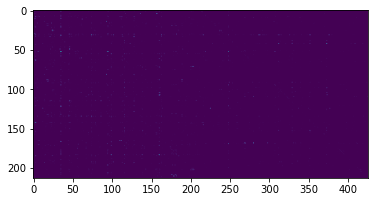

In [42]:
import matplotlib.pyplot as plt 
plt.imshow(weights)

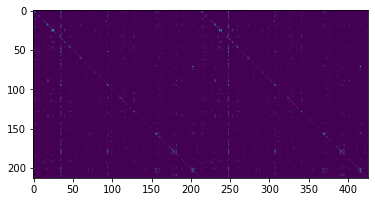

In [44]:
import matplotlib.pyplot as plt 
plt.imshow(knox_conn_matrix)

In [46]:
np.corrcoef(knox_conn_matrix.flatten(), weights.flatten())[0,1]

0.3795237493229223

### Subset old connectome/sources/targets to match Yohan's CCFv3 GE data

In [3]:
#load matrix with clearance genes
full_ge = pd.read_csv("/data/chamal/projects/natvik/sir_extended/analysis/combined_rgn_ge_df_filt_mr10vv0.2_colmean.csv", index_col=0)

In [4]:
full_ge

,0610005I03Rik*,0610006F12Rik*,0610007P14Rik,0610008A24Rik*,0610009B22Rik,0610009I12Rik*,0610009O20Rik,0610010F05Rik,0610012G03Rik,0610030E20Rik,...,Zscan5b,Zswim4,Zswim6,Zswim7,Zswim8,Zw10,Zwilch,Zxda,Zyg11a,Zyx
Accessory olfactory bulb,-11.790275,-5.640628,-0.545677,-6.913091,0.071856,-7.427888,1.383741,-0.537472,-0.766427,-0.561568,...,-0.026594,-0.159679,0.061266,-0.599246,1.404039,0.098360,0.079014,0.540049,-0.484916,-0.238447
Agranular insular area dorsal part,-1.199355,-1.390566,0.409159,-1.954314,-0.219818,-4.713010,1.492070,0.012643,1.666570,-0.063153,...,-0.324104,-0.179246,-0.002602,-0.087174,1.029784,0.339340,-0.393174,0.218492,-0.292730,0.747277
Agranular insular area posterior part,1.818689,1.339152,0.131983,1.434728,-0.279611,1.322285,-0.257014,0.114465,-2.291624,-0.467416,...,0.030501,-0.716440,0.041107,1.418019,-0.040352,-0.224996,-0.251194,0.009881,0.045645,-0.732416
Agranular insular area ventral part,-1.452324,-1.625483,-0.366505,-1.581378,-0.184791,-3.763743,1.133476,0.126299,1.017079,-0.135071,...,-0.309873,-0.204208,0.448121,-0.112075,0.587699,0.172923,-0.332740,0.202383,-0.258737,0.361462
Ansiform lobule,-6.325809,-8.101001,4.612405,-6.292236,-0.047881,-4.942791,1.608038,-0.591765,-0.781808,0.533437,...,-0.079613,0.106421,-0.668051,0.172358,-0.187079,-0.074602,0.241511,-0.427930,-0.082653,-0.844435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ventral posteromedial nucleus of the thalamus,2.002291,1.069682,-1.458997,1.122205,-0.049632,5.713195,0.298616,-0.029283,-0.772960,-0.156696,...,-0.123156,-0.236738,-0.414108,-0.035407,0.410003,-1.283370,-0.091050,-0.285880,-0.097028,-0.296548
Ventral posteromedial nucleus of the thalamus parvicellular part,-1.230784,-2.992747,-1.346902,-1.656942,0.127051,3.492229,-0.624655,0.213531,-0.289944,-0.029508,...,0.751381,-0.201990,-0.050012,0.134573,-0.288571,0.056378,0.101507,-0.088629,0.043491,2.434434
Ventral tegmental area,2.243870,2.829018,-1.782309,2.564600,0.213947,3.185228,0.239003,0.208316,-0.170445,0.075081,...,0.087724,-0.040217,-0.000486,0.106622,-1.343946,-0.230769,0.034272,-0.000521,0.166941,0.399148
Ventromedial hypothalamic nucleus,6.372799,9.294853,-0.359426,8.087623,0.231238,7.757597,-1.429732,0.366813,-1.685124,0.257414,...,0.225891,-0.088027,0.102375,-0.124919,0.692012,-0.881389,0.098266,-0.018175,0.184009,-1.441280


In [5]:
steph_allen_rgn_names = pd.read_csv('/data/chamal/projects/natvik/sir_extended/preprocessed/steph_inputs/ABAnewatlas_final_withacros.csv')
steph_allen_rgn_names

#change rownames of Yohan GE DF to have acronyms
rgn_name_to_acronym_dict = dict(zip(steph_allen_rgn_names['Structure'], steph_allen_rgn_names['acronym']))
acr_to_rgn_dict = dict(zip(steph_allen_rgn_names['acronym'], steph_allen_rgn_names['Structure']))

In [6]:
full_ge.index = [rgn_name_to_acronym_dict[i] for i in full_ge.index]

In [7]:
full_ge.to_csv('/data/chamal/projects/natvik/sir_extended/analysis/combined_rgn_ge_df_filt_mr10vv0.2_colmean_abbr.csv')

In [6]:
source_indices = np.where(np.isin(sources, full_ge.index))[0]
target_indices = np.where(np.isin(targets, full_ge.index))[0]

weights=weights[np.ix_(source_indices, target_indices)]
distance=distance[np.ix_(source_indices, target_indices)]
region_size = region_size[source_indices]
sources = np.array(sources)[source_indices]
targets = np.array(targets)[target_indices]

In [7]:
output_dir="/data/chamal/projects/natvik/sir_extended/analysis/"
with open(output_dir+'params_nature_yohan_ccfv3.pkl', 'wb') as f: #dropped regions with low resolution in CCFv3 template
    pickle.dump({'weights':weights, 'distance':distance, 
                 'region_size':region_size, 'sources':sources, 'targets':targets}, f)
    


### Chop up into individual files for each gene (makes IO faster)

In [18]:
input_dir = "/data/chamal/projects/natvik/sir_extended/analysis/"
with open(input_dir+'params_nature_yohan_ccfv3.pkl', "rb") as f:
    params = pickle.load(f)


with open(input_dir+'params_nature_retro_yohan_ccfv3.pkl', "rb") as f:
    params_retro = pickle.load(f)

sources = params['sources']
sources_retro = params_retro['sources']
sources == sources_retro

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
full_ge = pd.read_csv('/data/chamal/projects/natvik/sir_extended/analysis/combined_rgn_ge_df_filt_mr10vv0.2_colmean_abbr.csv', index_col=0)
df=full_ge
output_dir = '/data/chamal/projects/natvik/sir_extended/derivatives/yohan_ge_filt/mr10vv0.2/'

# Iterate through each column in the DataFrame
for column in df.columns:
    # Create a new DataFrame with only the current column
    new_df = df[[column]]
    new_df = new_df.loc[sources,:] #ensure regions are in the same order as params_nature_yohan_ccfv3.pkl before feeding into abm_clearance_genes.py - same as retro
    # Define the output CSV file name
    output_csv = f'{column}.csv'
    
    # Save the new DataFrame to the CSV file
    new_df.to_csv(output_dir+output_csv)
    
    #print(f'Saved {output_csv}')


In [21]:
ge_names_df = pd.DataFrame({"gene":df.columns})
ge_names_df.to_csv(output_dir+'gene_names_mr10vv0.2.csv',index=False)

### Extra: save all gene names, etc

In [28]:
unfilt_data = pd.read_csv("/data/chamal/projects/natvik/sir_extended/derivatives/combined_rgn_ge_df_full_vv0.csv",index_col=0)

In [30]:
output_dir = "/data/chamal/projects/natvik/sir_extended/derivatives/"
unfilt_ge_names_df = pd.DataFrame({"gene":unfilt_data.columns})
unfilt_ge_names_df.to_csv(output_dir+'combined_gene_names_vv0.csv',index=False)

In [24]:
ge_names = pd.read_csv(output_dir+'gene_names_mr10vv0.2.csv')

0       0610005I03Rik*
1       0610006F12Rik*
2        0610007P14Rik
3       0610008A24Rik*
4        0610009B22Rik
             ...      
8598              Zw10
8599            Zwilch
8600              Zxda
8601            Zyg11a
8602               Zyx
Name: gene, Length: 8603, dtype: object

In [13]:
Snca = pd.read_csv(output_dir+'Snca.csv', index_col=0)

In [10]:
source_df=pd.DataFrame([acr_to_rgn_dict[sources[i]] for i in range(len(sources))])
source_df.columns=['sources']
source_df.to_csv(output_dir+'yohan_source_full.csv')

with open('/data/chamal/projects/natvik/sir_extended/analysis/SIR_mouse/model/snca_nature.pickle', 'rb') as f:
    epr = pickle.load(f)

    syngene = norm.cdf(
        zscore(
            zscore(epr[0]) + zscore(epr[1])
            #zscore to the sum of the first and second elements of epr 
            #store the resulting values in the variable syngene
        )
    )

syngene_filtered = syngene[source_indices]
with open(output_dir+'shady_snca_rgn_filt.pkl', 'wb') as f: #dropped regions with low resolution in CCFv3 template
    pickle.dump({'syngene':syngene_filtered},f)

In [137]:
source_df

,sources
0,Accessory olfactory bulb
1,Anterior cingulate area dorsal part
2,Anterior cingulate area ventral part
3,Nucleus accumbens
4,Anterodorsal nucleus
...,...
204,Ventral posterolateral nucleus of the thalamus
205,Ventral posteromedial nucleus of the thalamus
206,Ventral posteromedial nucleus of the thalamus ...
207,Ventral tegmental area


In [17]:
full_ge = pd.read_csv('/data/chamal/projects/natvik/sir_extended/analysis/combined_rgn_ge_df_filt_mr20vv0.2_colmean.csv', index_col=0)
full_ge


,Unnamed: 0,0610005G16Rik*,0610005I03Rik*,0610006F12Rik*,0610007P14Rik,0610008A24Rik*,0610009B22Rik,0610009I12Rik*,0610009O20Rik,0610010F05Rik,...,Zswim8,Zufsp,Zw10,Zwilch,Zxda,Zxdc,Zyg11a,Zyx,Zzef1,Zzz3
0,Accessory olfactory bulb,-9.714671,-11.790275,-5.640628,-0.545677,-6.913091,0.071856,-7.427888,1.383741,-0.537472,...,1.404039,-0.389048,0.098360,0.079014,0.540049,-0.649932,-0.484916,-0.238447,-0.915544,0.258906
1,Agranular insular area dorsal part,-3.988421,-1.199355,-1.390566,0.409159,-1.954314,-0.219818,-4.713010,1.492070,0.012643,...,1.029784,-0.228997,0.339340,-0.393174,0.218492,-0.338195,-0.292730,0.747277,0.800999,1.228317
2,Agranular insular area posterior part,1.155758,1.818689,1.339152,0.131983,1.434728,-0.279611,1.322285,-0.257014,0.114465,...,-0.040352,0.070151,-0.224996,-0.251194,0.009881,0.075587,0.045645,-0.732416,-0.005072,-0.020507
3,Agranular insular area ventral part,-3.919622,-1.452324,-1.625483,-0.366505,-1.581378,-0.184791,-3.763743,1.133476,0.126299,...,0.587699,-0.262700,0.172923,-0.332740,0.202383,-0.269793,-0.258737,0.361462,0.642696,0.949274
4,Ansiform lobule,0.196652,-6.325809,-8.101001,4.612405,-6.292236,-0.047881,-4.942791,1.608038,-0.591765,...,-0.187079,0.010864,-0.074602,0.241511,-0.427930,-0.105917,-0.082653,-0.844435,0.387197,-0.652373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Ventral posteromedial nucleus of the thalamus,2.317781,2.002291,1.069682,-1.458997,1.122205,-0.049632,5.713195,0.298616,-0.029283,...,0.410003,0.009259,-1.283370,-0.091050,-0.285880,0.076878,-0.097028,-0.296548,-0.616289,-0.183411
205,Ventral posteromedial nucleus of the thalamus ...,-4.618477,-1.230784,-2.992747,-1.346902,-1.656942,0.127051,3.492229,-0.624655,0.213531,...,-0.288571,0.079332,0.056378,0.101507,-0.088629,0.009840,0.043491,2.434434,-0.524639,-0.248951
206,Ventral tegmental area,2.460205,2.243870,2.829018,-1.782309,2.564600,0.213947,3.185228,0.239003,0.208316,...,-1.343946,0.134628,-0.230769,0.034272,-0.000521,0.057131,0.166941,0.399148,-0.437851,-0.357852
207,Ventromedial hypothalamic nucleus,6.356309,6.372799,9.294853,-0.359426,8.087623,0.231238,7.757597,-1.429732,0.366813,...,0.692012,0.066314,-0.881389,0.098266,-0.018175,0.266429,0.184009,-1.441280,-0.685754,-1.323861


Transpose find_opt_params_clearance.R into python

In [51]:

input_dir="/data/chamal/projects/natvik/sir_extended/analysis/"
dbm_atrophy=pd.read_csv(input_dir+'rgn_t_stats_full_hemiMsPff_wtPBS.csv',index_col=0)

#REPLACE (or get rid)
sim_atrophy_data=pd.read_csv(input_dir+'SIR_mouse_results/yohan_abm_spread_v.35.0.spread_rate.0.01.dt.0.1.seed.35.injection_amount.1.0.clearance_gene.None.k1.0.5.k2.0.5.csv',header=None)
yohan_full = pd.read_csv(input_dir+'yohan_source_full.csv', index_col=0)
ABA_region_names = yohan_full
nregions = ABA_region_names.shape[0]
ABA_region_names = np.vstack((ABA_region_names,ABA_region_names)).flatten()

#process simulated atrophy data to get it in same form as Steph's DBM atrophies
sim_atrophy_data.index=ABA_region_names

alternating_values = np.repeat(["right","left"], nregions)
  
# Create unique row names based on first and last columns 
sim_atrophy_data.index = [alternating_values[i]+" "+list(sim_atrophy_data.index)[i] for i in range(len(sim_atrophy_data.index))]
results=dbm_atrophy
common_row_names = np.intersect1d(results.index, sim_atrophy_data.index)
# Get the common row names

# Sort matrices based on common row names
empirical_common = results.loc[common_row_names, :]
simulated_common = sim_atrophy_data.loc[common_row_names, :]
nsteps=simulated_common.shape[1]
correlations_tp3 = np.zeros(nsteps)
# Calculate Spearman correlation with each column in sim_atrophy_data
for i in range(nsteps):
  correlations_tp3[i] = scipy.stats.spearmanr(empirical_common.loc[:,"Time 3"], simulated_common.loc[:, i]).correlation

peak_corr = np.max(correlations_tp3)

In [52]:
peak_corr

0.636865798495156

In [ ]:
#change when working with Shady's full SNCA data (213 vs. 209 rgns)
ABA_region_names <- yohan_full
nregions <- nrow(ABA_region_names)
ABA_region_names<-rbind(ABA_region_names,ABA_region_names)


process_sim_atrophy_data <- function(ABA_region_names, sim_atrophy_data)
{
  sim_atrophy_data <- cbind(ABA_region_names, sim_atrophy_data) 
  
  alternating_values <- rep(c("right", "left"), each = nregions)
  sim_atrophy_data$hemisphere <- alternating_values
  
  # Create unique row names based on first and last columns 
  rownames(sim_atrophy_data) <- paste(sim_atrophy_data[, ncol(sim_atrophy_data)], sim_atrophy_data[, 1], sep = " ")
  
  sim_atrophy_data <- sim_atrophy_data[, -1] #get rid of region names
  sim_atrophy_data <- sim_atrophy_data[, -ncol(sim_atrophy_data)]
  return(sim_atrophy_data)
  
}

sim_atrophy_data <- process_sim_atrophy_data(ABA_region_names, sim_atrophy_data)
time_steps <- 1:ncol(sim_atrophy_data)  # Assuming the time steps are represented by column indices

# Get the common row names
common_row_names <- intersect(rownames(results), rownames(sim_atrophy_data))

# Sort matrices based on common row names
empirical_common <- results[common_row_names, ]
simulated_common <- sim_atrophy_data[common_row_names, ]

correlations_tp3 <- vector("numeric", length = ncol(simulated_common))
# Calculate Spearman correlation with each column in sim_atrophy_data
for (i in 1:ncol(simulated_common)) {
  correlations_tp3[i] <- cor(empirical_common[, 3], simulated_common[, i], method = "spearman")
}

correlation_data_t3 <- data.frame(Time_Steps = time_steps, Correlations = correlations_tp3)
peak_timestep <- correlation_data_t3$Time_Steps[which.max(correlation_data_t3$Correlations)]
peak_corr <- max(correlation_data_t3$Correlations)